In [2]:
#图象分类
#下载cifar10图象数据文件，pickle打包的数据，可用picke.load打开
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import optim
#引用学习率更新策略文件


In [8]:
'''
def unpickle(file):
    with open(file,'rb') as fr:
        imgData = pickle.load(fr,encoding='bytes')
    return imgData
'''

In [9]:
'''
trainData = unpickle(r'data/cifar-10-batches-py/data_batch_1')
#print(trainData.values())
testData = unpickle(r'data/cifar-10-batches-py/test_batch')
#print(testData.values())
'''

In [3]:
#读取数据
'''
需求：
10个类别
10分类任务

步骤一：
读data 
随机选 
训练集5000train
验证集500val 用于调参 w,b
测试集500test 固定好wb后，用新的test测下
'''
def load_CIFAR_batch(filename):
  """ 加载一个 batch数据 """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f,encoding='bytes')
    X = datadict[b'data']
    Y = datadict[b'labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ 加载所有CIFAR append到列表中并反回"""
  xs = []
  ys = []
  for b in range(1,2):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=5000, num_validation=500, num_test=500):

    # 设置默认值取train data5000, validation data 500, test data 500
    
    cifar10_dir = 'G://jt//tang//data//cifar-10-batches-py//'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    print("==全部数据未抽取前：==",X_train.shape)
    # 取数据样本
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # 归一化，计算数据平均值
    mean_image = np.mean(X_train, axis=0)
    #减平均值，变数据到以0为中间
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose 加一维channel通道，把通道换到第一维
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # 打包数据为字典
    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

In [4]:
data = get_CIFAR10_data()
print("==训练集数据X_train,y_train ==")
print(data['X_train'].shape)
print(data['y_train'].shape)
print("==验证集数据X_val,y_val ==")
print(data['X_val'].shape)
print(data['y_val'].shape)
print("==测试集数据X_train,y_train ==")
print(data['X_test'].shape)
print(data['y_test'].shape)

==全部数据未抽取前：== (10000, 32, 32, 3)
==训练集数据X_train,y_train ==
(5000, 3, 32, 32)
(5000,)
==验证集数据X_val,y_val ==
(500, 3, 32, 32)
(500,)
==测试集数据X_train,y_train ==
(500, 3, 32, 32)
(500,)


In [ ]:
'''
步骤二：
搭神经网络
relu函数做激活函数
输出是softmax多分类

最终得到 每个类别的概率值 p1 p2...p10
反向传播 求w

10分类
softmax公式 e^x/累加多个e^x，得到一个概率，外面加-log()，归一化处理。变成0到1
之间的规范点的数。

2分类
sigmoid公式 1/1+e^x
'''

In [5]:
#==前向传播、反向传播函数==
#带relu的前向传播，（第一层）
def affine_relu_forward(x,w,b):
    a,fc_cache = affine_forward(x,w,b)#wx+b隐层计算 返回隐层输出和cache
    out,relu_cache = relu_forward(a)#relu层计算
    cache = (fc_cache,relu_cache)#整合中间计算结果
    return out,cache
#隐层计算 （第二层直接用即可，第一层也调用了它加一个relu forward）
def affine_forward(x,w,b):
    out = None
    #取x行
    N = x.shape[0]
    #拉平为一行,纵向样本数据变行向，用于dot乘计算wx
    x_row = x.reshape(N,-1)
    #print("x_row:",x_row.shape)
    #print("w:",w.shape)
    out = np.dot(x_row,w)+b 
    #报报x_row w 维度相乘不匹配，原因：b2初始化时numclass写成hiddendim了
    cache = (x,w,b)
    return out,cache
#relu层计算
def relu_forward(x):
    out = None
    #out = ReLU(x)
    out = np.maximum(0,x)#relu计算公式 x>0返回x,x<=0返回0
    cache = x
    return out,cache

#softmax_loss层计算 (第二层接sofmax分类器)
def softmax_loss(x,y):
    #softmax公式e^x/累加每个e^x 求概率
    probs = np.exp(x - np.max(x,axis=1,keepdims=True))
    #prob概率 x- max(x) 求x变化值的概率，梯度
    probs /= np.sum(probs,axis=1,keepdims=True)
    #softmax loss公式 -log(probs) 归一化到0-1之间的概率值
    N= x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N),y]))/N #求平均loss
    #求梯度，对上面loss求导，
    #softmax max(0 x)求导公式为:正确类别y的结果-1
    dx = probs.copy()
    dx[np.arange(N),y] -=1#正确类别y的结果-1
    dx /= N #求平均？
    return loss,dx
    
#=反向传播= 
def affine_backward(dout,cache):#传入梯度和 w x b
    x,w,b = cache
    dx,dw,db = None,None,None
    dx = np.dot(dout,w.T) #(N,D)
    #针对公式wx+b对x求导 即w转置（WX对x求导为W.T）*前面传过来的导数（链式反向传导
    #dx拉平用于传给第二层计算
    dx = np.reshape(dx,x.shape)#变 （N,d1,d2,....d_k）
    #公式wx+b 对w求导 
    #先把x输入reshape拉平用于计算
    x_row = x.reshape(x.shape[0],-1)
    dw = np.dot(x_row.T,dout)#dw = x.T *上一层传过来的导数dout
    #对b求导，前面常数项消掉，b为常数，导数为1,
    #只乘下1*dout前面链式反向传导传过来的导数，累加，多少个b加起多少个dout即可
    db = np.sum(dout,axis=0,keepdims=True)
    
    return dx,dw,db

#带relu的反向传播（第一层，由上面通用隐层反向传播计算梯度函数 和 relu梯度计算函数组成）
def affine_relu_backward(dout,cache):
    fc_cache,relu_cache = cache
    da = relu_backward(dout,relu_cache)
    dx,dw,db = affine_backward(da,fc_cache)
    return dx,dw,db

#relu层梯度计算函数
def relu_backward(dout,cache):
    #max(0 x)计算公式 x>0时梯度=x,x《=0时梯度=0
    dx,x = None, cache
    dx = dout
    dx[x<=0]=0
    
    return dx



In [6]:
#定义神经网络骨架类
#搭两层架构，前向传播反向传播，各层等
class TwoLayerNet(object): 
    
    #==第一步：指定好骨格，初始化 w,b==
    #==参数==：
    #输入维度 3*32*32 深度3彩色 长32宽32
    #隐层神经元100个 隐层 用于存储wx+b的结果，
    #（非卷积神经网络，这个隐层也是一个全连接层，即前面的维度全部参与计算）
    #num_classes = 10 ,输出10个类别的概率，
    #权重初始化1e-10即10^（-3）
    #reg惩罚项系数，惩罚力度，惩罚权重项0.5w^2
    def __init__(self,input_dim=3*32*32,hidden_dim=100,num_classes=10,
                 weight_scale=1e-3,reg=0.0):
        
        self.params={}
        self.reg = reg
        #w1初始化 连接输入3*32*32和输出100个神经元 w*np.random.randn(input_dim,hidden_dim)
        self.params['W1'] = weight_scale*np.random.randn(input_dim,hidden_dim)
        #randn（m,n）random normal distribution生成m*n正太分布矩阵
        #w2 连接上一层的输出神经元和这层的输出，10个分类
        self.params['b1'] = np.zeros((1,hidden_dim))
        #b偏置向初始化，都用0 np.zeros()
        self.params['W2'] = weight_scale*np.random.randn(hidden_dim,num_classes)
        self.params['b2'] = np.zeros((1,num_classes))
       
    #==第二步：前向传播，反向传播==
    #loss函数，计算loss和梯度
    def loss(self,X,y=None):
        scores = None
        N = X.shape[0]
        #拿到W,b
        W1,b1 = self.params['W1'],self.params['b1']
        W2,b2 = self.params['W2'],self.params['b2']
        #前向传播第一层,返回隐层h1和cache1缓存（缓存保存中间值用于反向传播）
        h1,cache1 = affine_relu_forward(X,W1,b1)
        #前向传播第二层，连softmax分类器，这层没有relu（直接隐层计算wx+b即可），输入X为前一层计算结果h1,w2,b2
        out,cache2 = affine_forward(h1,W2,b2)
        #返回out是最后一层 wx+b的结果，cache2是此步中的w x b
        scores = out #最后一层wx+B计算结果输出即为得分（分类概率值）
        if y is None:#如果y为空，则为测试状态，返回分数
            return scores
        
        #==连softmax,把scores得分做0-1之间归一化操作，变分类概率==
        loss,grads = 0,{}
        data_loss,dscores = softmax_loss(scores,y)#返回loss和梯度
        #正则惩罚项loss = reg惩罚力度系数*0.5w^2
        reg_loss = 0.5 *self.reg*np.sum(W1*W1)+0.5 *self.reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        
        #==前向传播完，开始反向传播，把梯度传回计算w b，
        #找到合适的w b最终再更新模型，用于预测==
        #反向传播的过程是迭代求导，计算梯度的过程，
        #即让loss最小的方法就是梯度下降法，找到最近到山谷的距离时loss最小
        dh1, dW2, db2 = affine_backward(dscores,cache2)#传入softmax层的梯度（概率probs的导数）和cache2 即最后一层的w x b
        #上现返回softmax传回的计算梯度隐层输出dh1,dW2,db2
        #代入第一层，继续传播算梯度，注意，第一层有relu函数
        dX,dW1,db1 = affine_relu_backward(dh1,cache1)#传入上面传过来的梯度结果，和第一层的w x b
        
        #对正则惩罚项0.5w^2求导，即为w
        dW2 += self.reg*W2#reg为惩罚力度（系数）
        dW1 += self.reg*W1
        #梯度存入grads中
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2
        
        return loss, grads
        
        #反向传播 完
        #用最终求得的grads参数表 再进行前向传播，重新训练建模（更新模型）

    #以上完成了两层神经网络前向反向传播的架构，TwoLayerNet类
    

In [7]:
#==迭代训练类==
class Solver():
    #==初始化数据、参数==
    def __init__(self,model,data,**kwargs):#**kwargs不定长超参数，取时用kwargs.pop
        #指定数据 训练model; 训练集 验证集
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']
        
        self.update_rule = kwargs.pop('update_rule','sgd')#加sgd函数
        #指定学习率 LR 从0.1逐渐减小，一开始大步，后来逐步精细
        self.optim_config = kwargs.pop('optim_conig',{})
        self.lr_decay = kwargs.pop('lr_decay',1.0)
        #指定衰减率，self.lr_decay ，学习率以多大比例变化衰减
        self.batch_size = kwargs.pop('batch_size',100)
        #batch_size 100 每次训练多少张图象
        self.num_epochs = kwargs.pop('num_epochs',10)
        #epoch 10 迭代多少轮
        self.print_every = kwargs.pop('print_every',10)
        #迭代10次打印一次
        self.verbose = kwargs.pop('verbose',True)
        #不识别参数报错处理
        #……
        #更新学习率
        #self.update_rule = getattr(optim, self.update_rule)
        self._reset()#参数重置
    
    def _reset(self):
        self.epoch = 0 #第一个epoch=0
        self.best_val_acc = 0 #最好的验证准确率
        self.best_params = {} #最好的参数
        self.loss_history = [] #用于存储每步loss，用于画图
        self.train_acc_history = [] #用于存储每步训练精确度 准确率
        self.val_acc_history = []
        #找参数
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d
        
    #==开始训练网络==
    #训练迭代计步器
    def _step(self):
        #本函数意在，给train调用，
        #每步抽一个batch随机选batch_size拿出来，比如第100个
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train,self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]
        #选出的batch算loss和梯度
        #调用两层神经网络类中的loss方法求loss和grads
        loss,grads = self.model.loss(X_batch,y_batch)
        #loss存入loss列表
        self.loss_history.append(loss)
        
        #更新梯度
        '''
        
        for p, w in self.model.params.items():
          dw = grads[p]
          config = self.optim_configs[p]
          next_w, next_config = self.update_rule(w, dw, config)
          self.model.params[p] = next_w
          self.optim_configs[p] = next_config
        '''
    
    #验证
    def check_accuracy(self,X,y,num_samples=None,batch_size=100):
        #抽取一部分样本
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N,num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]
        #预测检验    
        num_batches = int(N / batch_size)
        if N % batch_size !=0:
            num_batches +=1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i+1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores,axis=1))
        y_pred = np.hstack(y_pred)#拼接矩阵
        acc = np.mean(y_pred ==y)#预测值==真实值的为正确，并求平均
        return acc
    
    
    #开始训练
    def train(self):
        num_train = self.X_train.shape[0]
        iterations_per_epoch = int(max(num_train/self.batch_size,1))#分几组
        num_iterations = self.num_epochs * iterations_per_epoch#总迭代次数
        for t in range(num_iterations):
            self._step()#依次迭代每次执行一步迭代计数器
            
            #打印
            if self.verbose and t % self.print_every == 0:
                print('第%d/%d次迭代，loss:%f'%(t+1,num_iterations,self.loss_history[-1]))
            
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1#epoch迭代计算器
            # 学习率调整：一开始大步，后面小步.
            '''
            
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay
            '''
            # 判断是否每一次第末次迭代，是否epoch结束
            first_it = (t == 0)
            last_it = (t == num_iterations + 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                                                num_samples=1000)
                val_acc = self.check_accuracy(self.X_val, self.y_val)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)

                if self.verbose:
                  print('第 %d / %d 轮, 训练精度: %f; 验证精度: %f' % (self.epoch, self.num_epochs, train_acc, val_acc))

                # 看看是否比上一组好，好的话更新
                if val_acc > self.best_val_acc:
                  self.best_val_acc = val_acc
                  self.best_params = {}
                  for k, v in self.model.params.items():
                    self.best_params[k] = v.copy()

            # 更新最好的参数
            self.model.params = self.best_params

        

In [8]:
#==调用上面data 神经网络model solver训练器
#实例化神经网络model
model = TwoLayerNet(reg=0.9)
#实例化训练器
solver = Solver(model,data,lr_decay=0.95,
                print_every=100,num_epochs=40,batch_size=400,
                update_rule='sgd_momentum',                
                optim_config={'learning_rate': 5e-4, 'momentum': 0.9}
               )
solver.train()#调取执行train实例对象方法



第1/480次迭代，loss:2.442556
第 0 / 40 轮, 训练精度: 0.087000; 验证精度: 0.078000
第 1 / 40 轮, 训练精度: 0.063000; 验证精度: 0.078000
第 2 / 40 轮, 训练精度: 0.069000; 验证精度: 0.078000
第 3 / 40 轮, 训练精度: 0.080000; 验证精度: 0.078000
第 4 / 40 轮, 训练精度: 0.072000; 验证精度: 0.078000
第 5 / 40 轮, 训练精度: 0.088000; 验证精度: 0.078000
第 6 / 40 轮, 训练精度: 0.074000; 验证精度: 0.078000
第 7 / 40 轮, 训练精度: 0.076000; 验证精度: 0.078000
第 8 / 40 轮, 训练精度: 0.083000; 验证精度: 0.078000
第101/480次迭代，loss:2.440872
第 9 / 40 轮, 训练精度: 0.074000; 验证精度: 0.078000
第 10 / 40 轮, 训练精度: 0.058000; 验证精度: 0.078000
第 11 / 40 轮, 训练精度: 0.057000; 验证精度: 0.078000
第 12 / 40 轮, 训练精度: 0.073000; 验证精度: 0.078000
第 13 / 40 轮, 训练精度: 0.079000; 验证精度: 0.078000
第 14 / 40 轮, 训练精度: 0.066000; 验证精度: 0.078000
第 15 / 40 轮, 训练精度: 0.085000; 验证精度: 0.078000
第 16 / 40 轮, 训练精度: 0.086000; 验证精度: 0.078000
第201/480次迭代，loss:2.440169
第 17 / 40 轮, 训练精度: 0.053000; 验证精度: 0.078000
第 18 / 40 轮, 训练精度: 0.077000; 验证精度: 0.078000
第 19 / 40 轮, 训练精度: 0.071000; 验证精度: 0.078000
第 20 / 40 轮, 训练精度: 0.075000; 验证精度: 0.078000
第 21 / 40 

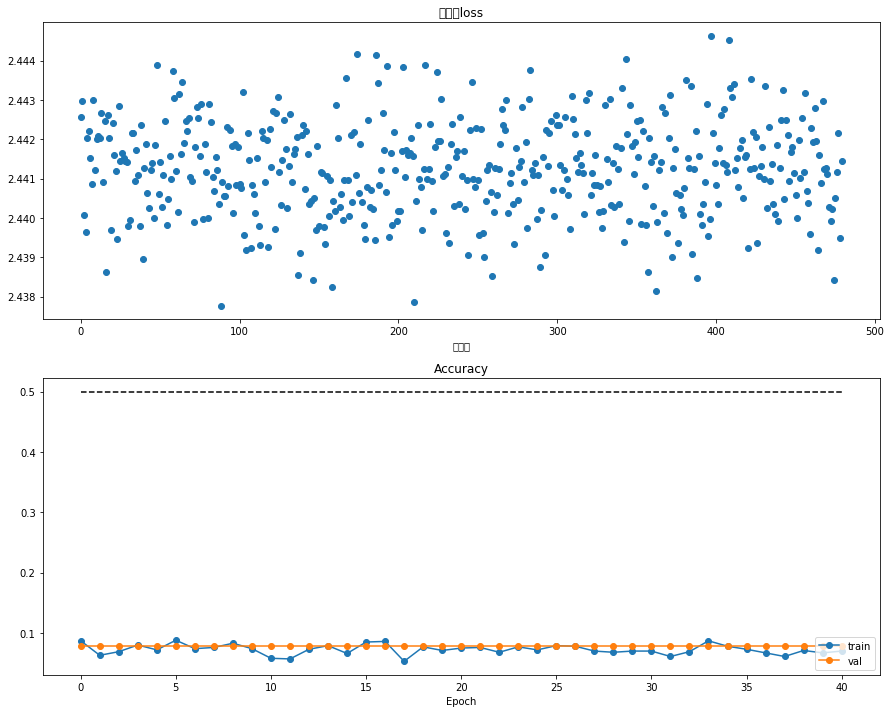

Validation set accuracy:  0.078
Test set accuracy:  0.074


In [9]:
#==画图==
plt.subplot(2,1,1)
plt.title('训练集loss')
plt.plot(solver.loss_history,'o')
plt.xlabel('迭代器')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history,'-o',label='train')
plt.plot(solver.val_acc_history,'-o',label='val')
plt.plot([0.5]*len(solver.val_acc_history),'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15,12)
plt.show()
#==测试==
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

In [10]:
#上面学习率更新策略待调
#==以下是tensorflow CNN来处理上面图象分类任务 (本任务待调)==
import tensorflow as tf
import time

In [ ]:
max_steps = 3000  # 训练轮数
batch_size = 128  # batch 大小
#data_dir = '/tmp/cifar10_data/cifar-10-batches-bin'  # 数据目录

# 权重初始化函数
# shape：卷积核参数，格式如[5,5,3,32]，代表卷积核尺寸（前两个数字），通道数和卷积核个数
# stddev：标准差
# wl：L2正则化的权值参数
# 返回带有L2正则的初始化的权重参数


def variable_with_weight_loss(shape, stddev, wl):
    var = tf.Variable(tf.truncated_normal(shape, stddev=stddev))
    # 截断产生正态分布，就是说产生正态分布的值如果与均值的差值大于两倍的标准差，
    # 那就重新生成。和一般的正太分布的产生随机数据比起来，这个函数产生的随机数
    # 与均值的差距不会超过两倍的标准差
    if wl is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var), wl, name='weight_loss')
        # 给权重W加上L2正则，并用wl参数控制L2 loss的大小
        tf.add_to_collection('losses', weight_loss)
        # 将weight loss存在一个名为‘losses’的collection里，后面会用到
    return var

# loss计算函数
# logits：未经softmax处理过的CNN的原始输出
# labels：样本标签
# 输出：总体loss值


def loss(logits, labels):

    labels = tf.cast(labels, tf.int64)  # 类型转换为tf.int64
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels, name='cross_entropy_per_example')
    # 计算结合softmax的交叉熵（即对logits进行softmax处理，由于softmax与cross_entropy经常一起用，
    # 所以TensorFlow把他们整合到一起了），算是一个标准范式
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    # 计算一个batch中交叉熵的均值
    tf.add_to_collection('losses', cross_entropy_mean)
    # 将交叉熵存在名为‘losses’的collection里

    return tf.add_n(tf.get_collection('losses'), name='total_loss')
    # 返回total loss，total loss包括交叉熵和上面提到的weight loss


#cifar10.maybe_download_and_extract()  # 下载数据集，并解压到默认位置


#images_train, labels_train = cifar10_input.distorted_inputs(data_dir=data_dir,
#                                                            batch_size=batch_size)
# 产生训练需要的数据，每次执行都会生成一个batch_size的数量的样本（这里进行了样本扩张）
images_train,labels_train = data['X_train'],data['y_train']

        
#images_test, labels_test = cifar10_input.inputs(eval_data=True,
#                                                data_dir=data_dir,
#                                                batch_size=batch_size)
# 产生训练需要的测试数据，每次执行都会生成一个batch_size的数量的测试样本
images_test, labels_test = data['X_val'],data['y_val']

image_holder = tf.placeholder(tf.float32, [batch_size, 24, 24, 3])
label_holder = tf.placeholder(tf.int32, [batch_size])
# 创建输入数据的placeholder（相当于占位符）

weight1 = variable_with_weight_loss(shape=[5, 5, 3, 64], stddev=5e-2, wl=0.0)
# 第一层权重初始化，产生64个3通道（RGB图片），尺寸为5*5的卷积核，不带L2正则（wl=0.0）
kernel1 = tf.nn.conv2d(image_holder, weight1, [1, 1, 1, 1], padding='SAME')
# 对输入原始图像进行卷积操作，步长为[1, 1, 1, 1]，即将每一个像素点都计算到，
# 补零模式为'SAME'（不够卷积核大小的块就补充0）
bias1 = tf.Variable(tf.constant(0.0, shape=[64]))
# 定义第一层的偏置参数，由于有64个卷积核，这里有偏置尺寸为shape=[64]
conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, bias1))
# 卷积结果加偏置后采用relu激活
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                       padding='SAME')
# 第一层的池化操作，使用尺寸为3*3，步长为2*2的池化层进行操作
# 这里的ksize和strides第一个和第四个数字一般都为1
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
# 用LRN对结果进行处理，使得比较大的值变得更大，比较小的值变得更小，模仿神经系统的侧抑制机制

# 这一部分和上面基本相同，不加赘述
weight2 = variable_with_weight_loss(shape=[5, 5, 64, 64], stddev=5e-2, wl=0.0)
kernel2 = tf.nn.conv2d(norm1, weight2, [1, 1, 1, 1], padding='SAME')
bias2 = tf.Variable(tf.constant(0.1, shape=[64]))
conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, bias2))
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                       padding='SAME')

# 这里定义一个全连接层
reshape = tf.reshape(pool2, [batch_size, -1])
# 将上一层的输出结果拉平（flatten），[batch_size, -1]中的-1代表不确定多大
dim = reshape.get_shape()[1].value
# 得到数据扁平化后的长度

# 建立一个隐含节点数为384的全连接层
weight3 = variable_with_weight_loss(shape=[dim, 384], stddev=0.04, wl=0.004)
bias3 = tf.Variable(tf.constant(0.1, shape=[384]))
local3 = tf.nn.relu(tf.matmul(reshape, weight3) + bias3)

# 建立一个隐含节点数为192的全连接层
weight4 = variable_with_weight_loss(shape=[384, 192], stddev=0.04, wl=0.004)
bias4 = tf.Variable(tf.constant(0.1, shape=[192]))
local4 = tf.nn.relu(tf.matmul(local3, weight4) + bias4)

# 建立输出层（由于cifar数据库一共有10个类别的标签，所以这里输出节点数为10）
weight5 = variable_with_weight_loss(shape=[192, 10], stddev=1/192.0, wl=0.0)
bias5 = tf.Variable(tf.constant(0.0, shape=[10]))
logits = tf.add(tf.matmul(local4, weight5), bias5)
# 注意这里，这里直接是网络的原始输出（wx+b这种形式），没有加softmax激活

loss = loss(logits, label_holder)
# 计算总体loss，包括weight loss 和 cross_entropy

train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
# 选择AdamOptimizer作为优化器

top_k_op = tf.nn.in_top_k(logits, label_holder, 1)
# 关于tf.nn.in_top_k函数的用法见http://blog.csdn.net/uestc_c2_403/article/details/73187915
# tf.nn.in_top_k会返回一个[batch_size, classes(类别数)]大小的布尔型张量，记录是否判断正确

sess = tf.InteractiveSession()  # 注册为默认session
tf.global_variables_initializer().run()  # 初始化全部模型参数

tf.train.start_queue_runners()  # 启动线程（QueueRunner是一个不存在于代码中的东西，而是后台运作的一个概念）

for step in range(max_steps):
    start_time = time.time()
    image_batch, label_batch = sess.run([images_train, labels_train])
    # 获得一个batch的训练数据
    _, loss_value = sess.run([train_op, loss], feed_dict={image_holder: image_batch,
                                                          label_holder: label_batch})
    # 运行训练过程并获得一个batch的total_loss

    duration = time.time() - start_time  # 记录跑一个batch所耗费的时间

    if step % 10 == 0:  # 每10个batch输出信息
        examples_per_sec = batch_size / duration  # 计算每秒能跑多少个样本
        sec_per_batch = float(duration)  # 计算每个batch需要耗费的时间

        format_str = (
            'step %d, loss = %.2f (%.1f examples/sec; %.3f sec/batch)')
        print(format_str % (step, loss_value, examples_per_sec, sec_per_batch))

# 在测试集上验证精度
num_examples = 10000
import math
num_iter = int(math.ceil(num_examples / batch_size))  # math.ceil 对浮点数向上取整
true_count = 0
total_sample_count = num_iter * batch_size
step = 0
while step < num_iter:
    image_batch, label_batch = sess.run([images_test, labels_test])
    # 获得一个batch的测试数据
    predictions = sess.run([top_k_op], feed_dict={image_holder: image_batch,
                                                  label_holder: label_batch})
    true_count += np.sum(predictions)  # 获得预测正确的样本数
    step += 1

precision = true_count / total_sample_count  # 获得预测精度
print('precision @ 1 = %.4f' % precision*100)

